## Install dependencies

In [ ]:
!pip install torch torchvision transformers datasets matplotlib scikit-learn evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

## Classification with ViT

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
import evaluate

import numpy as np
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

train_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=10,
    ignore_mismatched_sizes=True
)
model.to(device)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()

def train(model, loader):
    model.train()
    total_loss = 0
    for batch in loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(pixel_values=inputs)
        loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [ ]:
def evaluate(model, loader):
    model.eval()
    preds, labels_all = [], []
    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            outputs = model(pixel_values=inputs)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1).cpu().numpy()

            preds.extend(predictions)
            labels_all.extend(labels.numpy())
    return preds, labels_all


In [ ]:
for epoch in range(5):
    loss = train(model, train_loader)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

preds, labels = evaluate(model, test_loader)
print(classification_report(labels, preds, target_names=train_dataset.classes))

Epoch 1, Loss: 0.1066
Epoch 2, Loss: 0.0290
Epoch 3, Loss: 0.0229
Epoch 4, Loss: 0.0187
Epoch 5, Loss: 0.0140
              precision    recall  f1-score   support

    airplane       0.98      0.99      0.99      1000
  automobile       0.97      0.99      0.98      1000
        bird       0.99      0.98      0.99      1000
         cat       0.96      0.94      0.95      1000
        deer       0.97      0.99      0.98      1000
         dog       0.97      0.95      0.96      1000
        frog       0.99      0.99      0.99      1000
       horse       0.99      0.99      0.99      1000
        ship       0.99      0.99      0.99      1000
       truck       0.99      0.97      0.98      1000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



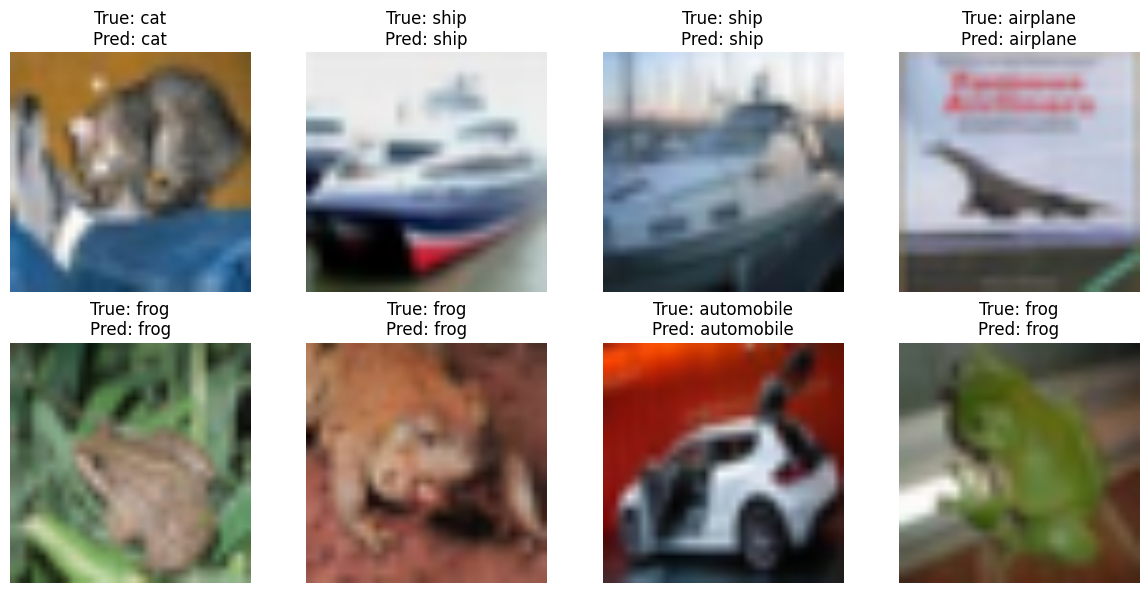

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Mapea índices a nombres de clases
class_names = train_dataset.classes

# Muestra algunas predicciones
def show_predictions(model, loader, num_images=8):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, 6))
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(pixel_values=inputs.to(model.device))
            preds = torch.argmax(outputs.logits, dim=1)

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    break
                image = inputs[i].cpu().permute(1, 2, 0).numpy()
                image = (image * np.array(feature_extractor.image_std) +
                         np.array(feature_extractor.image_mean))
                image = np.clip(image, 0, 1)

                plt.subplot(2, 4, images_shown + 1)
                plt.imshow(image)
                plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
                plt.axis("off")
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.tight_layout()
    plt.show()

# Llamar a la función
show_predictions(model, test_loader)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.jpg to test.jpg


In [ ]:
from PIL import Image
import torch
from transformers import ViTFeatureExtractor

# Cargar la imagen
image = Image.open("/content/test.jpg").convert("RGB")

# Preprocesar con el feature_extractor entrenado
inputs = feature_extractor(images=image, return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}


In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()

# Mostrar la clase predicha
print("Predicción:", train_dataset.classes[predicted_class_idx])

Predicción: airplane


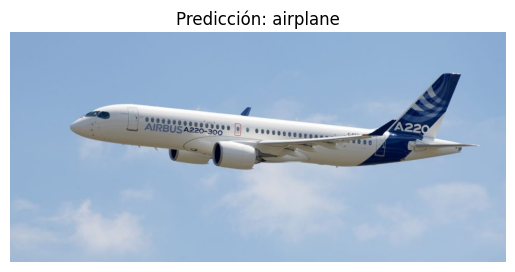

In [ ]:
plt.imshow(image)
plt.title(f"Predicción: {train_dataset.classes[predicted_class_idx]}")
plt.axis("off")
plt.show()

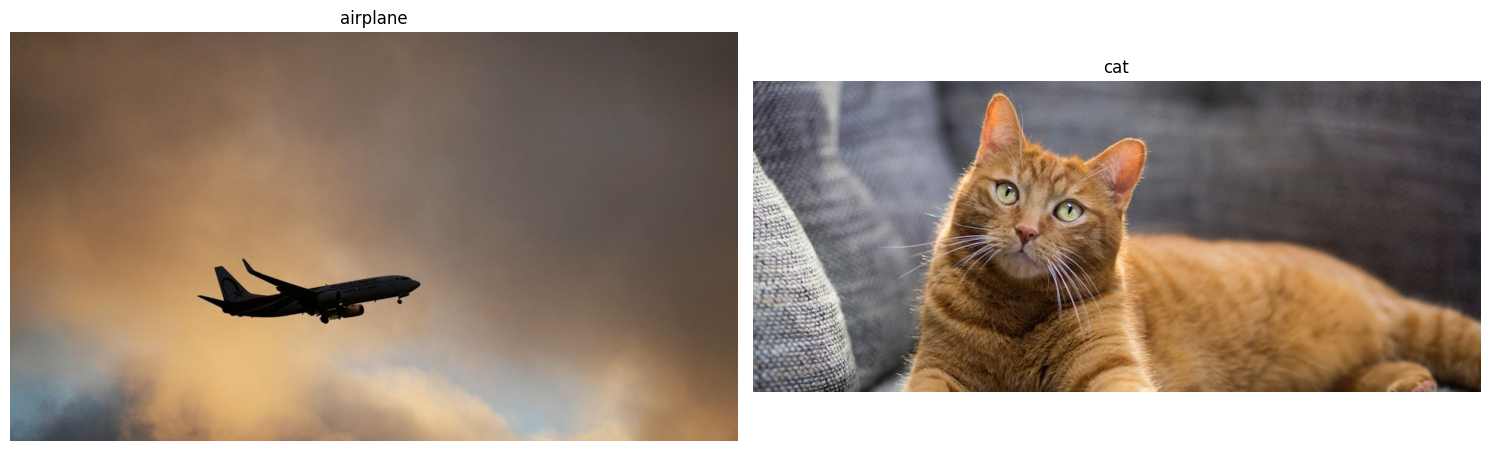

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def load_image_from_url(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

# Lista de URLs de imágenes
urls = [
    "https://static.euronews.com/articles/stories/08/69/95/16/1366x768_cmsv2_59d41854-f375-5160-837c-6e16c649690b-8699516.jpg",
    "https://cdn.royalcanin-weshare-online.io/tlYzqG0BBKJuub5qNVnB/v1/67-es-l-cat-in-a-sofa-thinking-getting-dog-gato-adecuado?w=960&fm=jpg&auto=format%2Ccompress"
]

plt.figure(figsize=(15, 5))
for i, url in enumerate(urls):
    image = load_image_from_url(url)
    inputs = feature_extractor(images=image, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    pred = outputs.logits.argmax(-1).item()
    plt.subplot(1, len(urls), i + 1)
    plt.imshow(image)
    plt.title(f"{train_dataset.classes[pred]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Segmentation using segformer

In [ ]:
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation

model_id = "nvidia/segformer-b0-finetuned-ade-512-512"

processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForSemanticSegmentation.from_pretrained(model_id)
model.eval()


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [ ]:
from google.colab import files
from PIL import Image

uploaded = files.upload()
image = Image.open(next(iter(uploaded))).convert("RGB")

Saving test2.jpg to test2.jpg


In [ ]:
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
logits = outputs.logits  # [1, num_classes, H, W]
upsampled_logits = torch.nn.functional.interpolate(
    logits,
    size=image.size[::-1],  # (H, W)
    mode="bilinear",
    align_corners=False
)
predicted = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

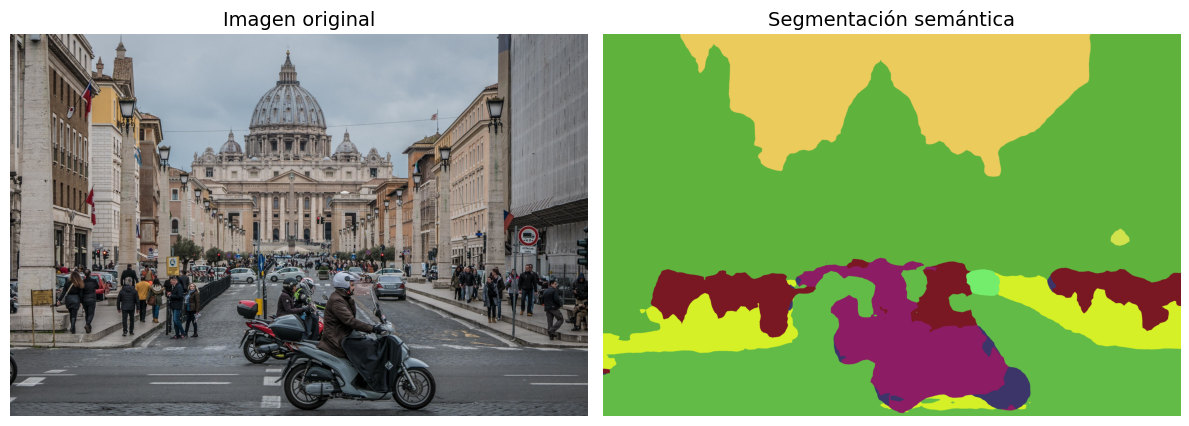

In [ ]:
import matplotlib.patches as mpatches
from torchvision import transforms

# Usamos una paleta fija de ADE20K (opcionalmente puedes cargarla)
# Aquí generamos una aleatoria pero reproducible
np.random.seed(42)
palette = np.random.randint(0, 255, size=(150, 3), dtype=np.uint8)

# Convertir la predicción a imagen RGB con la paleta
seg_image = palette[predicted]

# Mostrar la imagen original y la segmentación
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image)
axes[0].set_title("Imagen original", fontsize=14)
axes[0].axis("off")

axes[1].imshow(seg_image)
axes[1].set_title("Segmentación semántica", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()


## Visualize Attention Proccess

#### ¿Qué es la atención en ViT?


ViT divide la imagen en patches, y luego aplica self-attention entre todos ellos. En cada capa y cabeza del Transformer, el modelo genera una matriz de atención que indica cuánto se enfoca un patch en otro.

En clasificación, se usa un token especial [CLS], que se entrena para resumir la imagen.

El mapa de atención que más nos interesa es:


> ¿Qué tanto cada patch influye sobre el [CLS] token?



In [ ]:
from transformers import ViTModel, ViTFeatureExtractor
import torch

model_id = "google/vit-base-patch16-224-in21k"

model = ViTModel.from_pretrained(model_id, output_attentions=True)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [ ]:
from PIL import Image
from google.colab import files

uploaded = files.upload()
image = Image.open(next(iter(uploaded))).convert("RGB")

Saving test2.jpg to test2 (2).jpg


In [ ]:
inputs = feature_extractor(images=image, return_tensors="pt")

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)

# Atenciones: lista de tensores (uno por capa), shape: [batch, num_heads, tokens, tokens]
attentions = outputs.attentions  # List[Tensor]

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


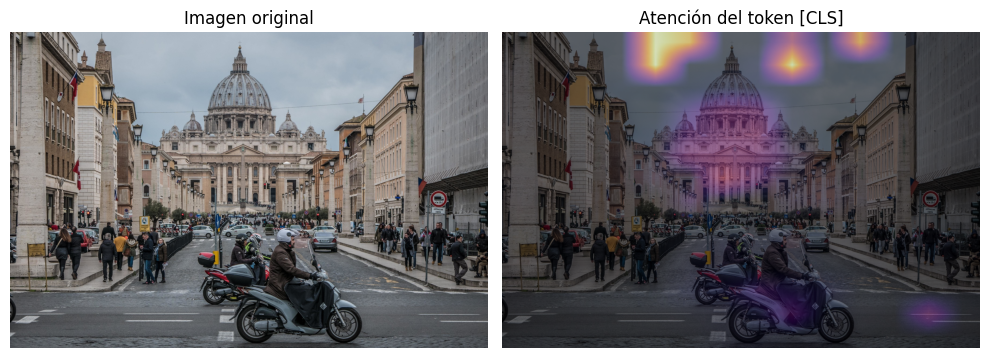

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Elegimos la última capa
last_attn = attentions[-1]  # [1, num_heads, tokens, tokens]

# Promediamos sobre las cabezas
avg_attn = last_attn[0].mean(dim=0)  # [tokens, tokens]

# Tomamos atención del token [CLS] sobre los patches
cls_attn = avg_attn[0, 1:]  # Ignoramos el [CLS] (solo queremos atención de [CLS] hacia los otros)

# El modelo usa 14x14 = 196 patches
num_patches = int(cls_attn.shape[0] ** 0.5)
attn_map = cls_attn.reshape(num_patches, num_patches).numpy()
attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())  # normalizamos

# Redimensionamos al tamaño de la imagen original
attn_resized = F.interpolate(torch.tensor(attn_map)[None, None], size=image.size[::-1], mode="bilinear")[0, 0]

# Mostrar sobre imagen
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Imagen original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(attn_resized, cmap='inferno', alpha=0.5)
plt.title("Atención del token [CLS]")
plt.axis("off")

plt.tight_layout()
plt.show()

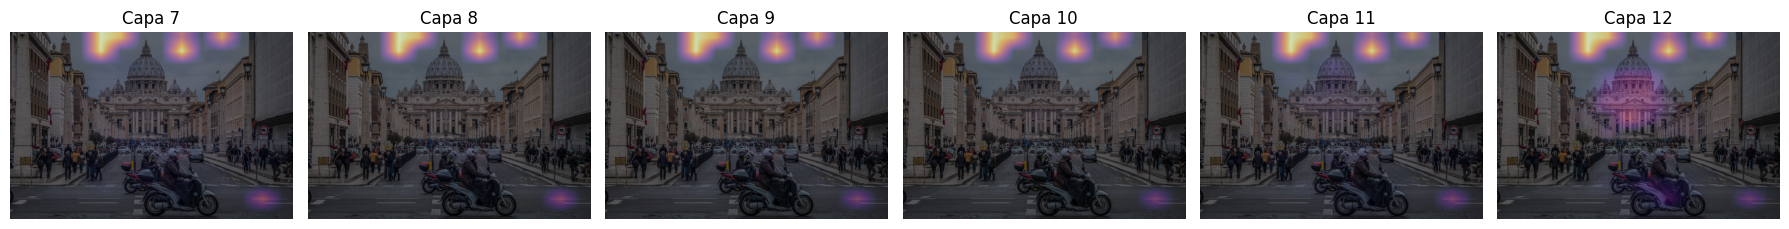

In [ ]:
# Configura número de capas que quieres ver
num_layers_to_plot = 6  # por ejemplo, 6 capas
selected_layers = list(range(len(attentions) - num_layers_to_plot, len(attentions)))

# Visualiza atención promedio del CLS por capa
fig, axes = plt.subplots(1, num_layers_to_plot, figsize=(18, 4))

for idx, layer in enumerate(selected_layers):
    attn = attentions[layer][0]  # [num_heads, tokens, tokens]
    attn_cls = attn.mean(0)[0, 1:]  # atención del CLS sobre los patches
    attn_map = attn_cls.reshape(14, 14).numpy()
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

    attn_resized = F.interpolate(torch.tensor(attn_map)[None, None], size=image.size[::-1], mode="bilinear")[0, 0]

    axes[idx].imshow(image)
    axes[idx].imshow(attn_resized, cmap='inferno', alpha=0.5)
    axes[idx].set_title(f"Capa {layer+1}")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
!pip install imageio imageio-ffmpeg --quiet

In [ ]:
import imageio
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F

os.makedirs("attention_frames", exist_ok=True)
frame_paths = []

print("Generando frames...")

for layer_idx, attn_tensor in enumerate(attentions):
    attn = attn_tensor[0]  # [num_heads, tokens, tokens]
    for head_idx in range(attn.shape[0]):
        attn_cls = attn[head_idx, 0, 1:]  # atención del token CLS sobre patches
        attn_map = attn_cls.reshape(14, 14).numpy()
        attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

        attn_resized = F.interpolate(torch.tensor(attn_map)[None, None], size=image.size[::-1], mode="bilinear")[0, 0]

        # Graficar y guardar el frame
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(image)
        ax.imshow(attn_resized, cmap="inferno", alpha=0.5)
        ax.set_title(f"Capa {layer_idx+1} - Cabeza {head_idx+1}", fontsize=14)
        ax.axis("off")

        frame_path = f"attention_frames/frame_{layer_idx:02d}_{head_idx:02d}.png"
        plt.savefig(frame_path, bbox_inches="tight")
        frame_paths.append(frame_path)
        plt.close(fig)

Generando frames...


In [ ]:
video_path = "attention_map_video.mp4"
imageio.mimsave(video_path, [imageio.imread(f) for f in frame_paths], fps=6)

/tmp/ipython-input-10-2196245981.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave(video_path, [imageio.imread(f) for f in frame_paths], fps=6)


In [ ]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open("attention_map_video.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=600 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")

In [ ]:
from google.colab import files
files.download(video_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Instance segmentation

In [ ]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()
model.cuda()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 62.5MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
from google.colab import files

uploaded = files.upload()
image_path = next(iter(uploaded))
image = Image.open(image_path).convert("RGB")

Saving test2.jpg to test2 (3).jpg


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
image_tensor = transform(image).unsqueeze(0).cuda()  # [1, 3, H, W]

In [ ]:
with torch.no_grad():
    outputs = model(image_tensor)

# Extraer resultados
pred = outputs[0]

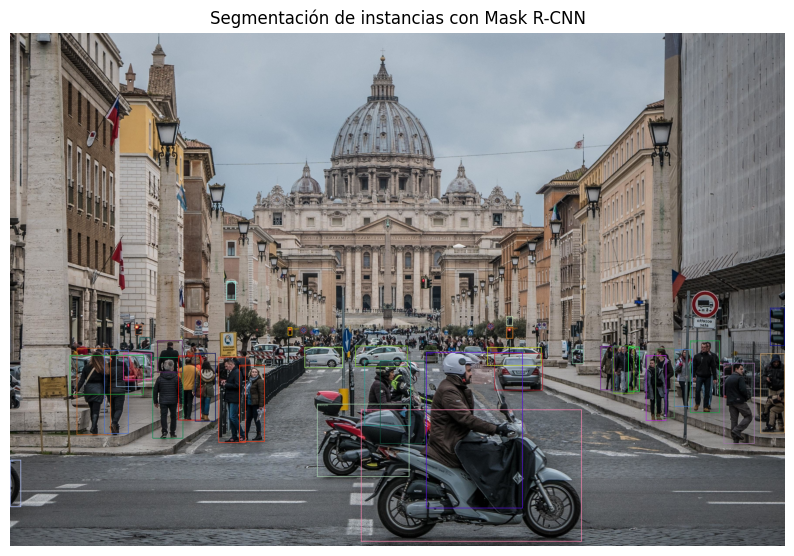

In [ ]:
def plot_instance_segmentation(image, pred, score_threshold=0.7):
    image = image.copy()
    draw = ImageDraw.Draw(image)
    masks = pred["masks"]
    boxes = pred["boxes"]
    labels = pred["labels"]
    scores = pred["scores"]

    COCO_INSTANCE_CATEGORY_NAMES = [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
        'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
        'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
        'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
        'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
        'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]

    for i in range(len(scores)):
        if scores[i] < score_threshold:
            continue
        box = boxes[i].cpu().numpy()
        label = COCO_INSTANCE_CATEGORY_NAMES[labels[i]]
        color = tuple(np.random.randint(0, 255, 3).tolist())

        # Dibujar bounding box
        draw.rectangle(box.tolist(), outline=color, width=3)
        draw.text((box[0], box[1]), label, fill=color)

        # Dibujar máscara
        mask = masks[i, 0].cpu().numpy()
        mask_image = Image.fromarray((mask > 0.5).astype(np.uint8) * 100)
        image.paste(Image.fromarray(np.uint8(np.array(image) * (mask[:, :, None] > 0.5))), (0, 0), mask_image)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Segmentación de instancias con Mask R-CNN")
    plt.show()

plot_instance_segmentation(image, pred)


## Pose Estimation

In [ ]:
!pip install mediapipe opencv-python --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.


In [ ]:
!pip uninstall -y mediapipe protobuf
!pip install mediapipe==0.10.9 protobuf==3.20.3 opencv-python

Found existing installation: protobuf 5.29.5
Uninstalling protobuf-5.29.5:
  Successfully uninstalled protobuf-5.29.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 9.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.


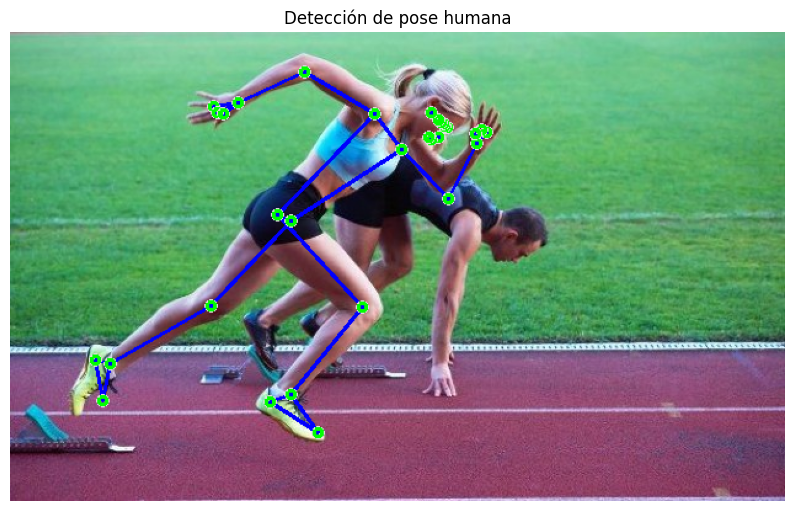

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Inicializar pose y drawing utils
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Cargar imagen (reemplaza por tu archivo si quieres)
image_path = "/content/pose.jpeg"  # O usa files.upload() para subir una
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Procesar imagen
with mp_pose.Pose(static_image_mode=True) as pose:
    results = pose.process(image_rgb)

    # Dibujar keypoints y conexiones
    annotated = image_rgb.copy()
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated,
            landmark_list=results.pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=3),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0,0,255), thickness=2),
        )

# Mostrar resultado
plt.figure(figsize=(10, 10))
plt.imshow(annotated)
plt.axis("off")
plt.title("Detección de pose humana")
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Akros, 1 minuto. Parkour.mp4 to Akros, 1 minuto. Parkour.mp4


In [ ]:
import cv2
import mediapipe as mp
import os

# Inicializar pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

input_path = '/content/Akros, 1 minuto. Parkour.mp4'
output_path = 'video_con_pose.mp4'

# Abrir video de entrada
cap = cv2.VideoCapture(input_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Crear video de salida
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

with mp_pose.Pose(static_image_mode=False) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convertir BGR a RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        # Dibujar landmarks
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=2),
                connection_drawing_spec=mp_drawing.DrawingSpec(color=(255,0,0), thickness=2)
            )

        out.write(frame)

cap.release()
out.release()


In [ ]:
from google.colab import files
files.download('video_con_pose.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>